In [0]:
# Shared by all
import os, pickle
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils # We should use this eventually.
from torch import nn, optim
from torch.nn import functional as F
import numpy as np

# For DataLoader
from PIL import Image
import numbers
import matplotlib.pyplot as plt

import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

In [2]:
from google.colab import drive
drive.mount('/content/drive/' )#, force_remount=True)

base = '/content/drive/My Drive/School/Fall 2019/ESE 546/project/'
os.makedirs(base+'checkpoints', exist_ok=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


### Dataset Code: `VelocityPredicitionCaralDataset.py`

In [0]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils # We should use this eventually.
from PIL import Image
import numbers
import glob

class VelocityPredictionCarlaDataSet(Dataset):
    def __init__(self, data_dir, goal_images={}, delta=100, load_as_grayscale=False, transform=None):
        # xcxc I'm assuming that the images live in _out.
        self.data_dir = data_dir
        self.transform = transform
        self.goal_images = goal_images
        self.delta = delta
        self.load_as_grayscale = load_as_grayscale
        self.df = self._get_dataframe()
    
    def __len__(self):
        num_rows, _ = self.df.shape
        return num_rows
    
    def __getitem__(self, idx):
        '''
        Generate one sample of data.
        '''
        row = self.df.iloc[idx]
        ctr1 = float(row['ctr1'])
        ctr2 = float(row['ctr2'])
        control_inputs = np.array([ctr1, ctr2])
        src_img = self._load_image_and_maybe_apply_transform(row['src'])
        tgt_img = self._load_image_and_maybe_apply_transform(row['tgt'])
        return (src_img, tgt_img, control_inputs)

    def _load_image_and_maybe_apply_transform(self, filename):
        '''
        Inputs:
            image_loc: The location of the image we want to load
        Outputs:
            Either the grayscale image, a RGB image with the axes flopped, or 
            the RGB image with some series of transformations applied. 
            All are converted to numpy arrays before yeeting them out.
        '''
        # I've been writing too much haskell
        image_loc = os.path.join(self.data_dir, '_out', filename)
        pil_img = Image.open(image_loc)
        if self.load_as_grayscale:
            pil_img = pil_img.convert('L')
        
        if self.transform:
            transform_result = self.transform(pil_img)
            return np.asarray(transform_result[:3, :, :])
        else:
            if self.load_as_grayscale:
                return np.array(pil_img)
            else:
                return self._rearrange_axes_image(np.array(pil_img))

    def _rearrange_axes_image(self, img):
        H,W,_ = img.shape
        new_img = np.zeros((3,H,W))
        for i in range(3):
            new_img[i,:,:] = img[:,:,i]
        return new_img

    def _get_dataframe(self):
        control_input_df = self._get_control_input_df()
        control_input_df['input_num'] = control_input_df['input_num'].astype('int') 
        filename_df = self._get_image_path_df()
        pairwise_df = self._get_pairwise_df(filename_df)
        pairwise_df['index'] = pairwise_df['index'].astype('int')
        df = control_input_df.merge(right=pairwise_df,
                                    left_on=['input_num', 'trajectory'],
                                    right_on=['index', 'trajectory'])
        stationary_mask = (df['src'] == df['tgt'])
        ctr1_col = df['ctr1'].copy()
        ctr2_col = df['ctr2'].copy()
        ctr1_col[stationary_mask] = 0
        ctr2_col[stationary_mask] = 0
        df['ctr1'] = ctr1_col
        df['ctr2'] = ctr2_col
        df = df[['trajectory', 'index', 'ctr1', 'ctr2', 'src', 'tgt']]
        return df.drop_duplicates()

    def _get_control_input_df(self):
        # xcxc I'm also assuming that our columns in control_input stay static like so.
        control_input_df = pd.read_csv(os.path.join(self.data_dir, 'control_input.txt'),
                               names=['trajectory', 'input_num', 'ctr1', 'ctr2'])
        control_input_df['input_num'] = control_input_df['input_num'].astype('str')
        control_input_df['trajectory'] =control_input_df['trajectory'].astype('str')
        return control_input_df
    
    def _get_image_path_df(self):
        '''
        Different from the OG CarlaDS.
        This returns a dataframe of the 
        '''
        all_files_in_out = self._get_image_files_in_directory()
        # We can then make a map with our data...
        filename_groupings = {}
        for fn in all_files_in_out:
            # Apologies for the hardcoding
            fn_number = str(int(fn.split('_')[0]))
            trajectory_number = str(int(fn.split('_')[2].split('.')[0]))
            if (fn_number, trajectory_number) not in filename_groupings:
                filename_groupings[(fn_number, trajectory_number)] = []
            filename_groupings[(fn_number, trajectory_number)].append(fn)
            
        # Then make a dataframe from this dictionary
        filename_df = self._get_initial_filename_dataframe(filename_groupings)
        return filename_df
    
    def _get_initial_filename_dataframe(self, filename_groupings):
        '''
        Given the filename groupings from the above, create a dataframe
        of the schema [trajectory, index, image1, image2]
        '''
        filename_df = pd.DataFrame(columns=['trajectory', 'index', 'src'])
        for k,v in filename_groupings.items():
            (index, traj) = k
            img1 = None
            if len(v) == 1:
                img1 = v[0]
            filename_df = filename_df.append({
                'trajectory': traj,
                'index': index,
                'src': img1
            }, ignore_index=True)
        filename_df['trajectory'] = filename_df['trajectory'].astype('str')
        filename_df['index'] = filename_df['index'].astype('int')
        filename_df = filename_df.dropna(subset=['src']) # Drop if any of our images is None.
        return filename_df
    
    def _get_pairwise_df(self, filename_df):
        pairwise_df = pd.DataFrame(columns=['trajectory', 'index', 'src', 'tgt'])
        trajectory_map = self._construct_trajectory_map(filename_df)
        for trajectory, goal_fn in trajectory_map.items():
            fn_subset_df = filename_df[filename_df['trajectory']==trajectory]
            pairwise_df = self._get_pairwise_combinations_for_goal(
                goal_fn, fn_subset_df, pairwise_df)
        pairwise_df['trajectory'] = pairwise_df['trajectory'].astype('str')
        pairwise_df['index'] = pairwise_df['index'].astype('str')
        return pairwise_df
    
    def _construct_trajectory_map(self, filename_df):
        '''
        Constructs a map such that
        {trajectory: goal}
        So then it's just a matter of iterating through this map.
        '''
        if len(self.goal_images) > 0:
            return self.goal_images
        trajectories = filename_df['trajectory'].unique().tolist()
        def helper(traj):
            return filename_df[filename_df['trajectory']==traj]['src'].max()
            
        goal_filenames = map(lambda t: helper(t), trajectories)
        goal_filenames = list(goal_filenames)
        return {trajectories[i]: goal_filenames[i] for i in range(len(trajectories))}
    
    def _get_pairwise_combinations_for_goal(self, goal_image, filename_df, pairwise_df):
        '''
        With filename_df, we construct the ('index', 'src', 'tgt' here), constructed by 
        '''
        num_rows, _ = filename_df.shape
        tgt_index = int(goal_image.split('_')[0]) # Get which # image we want to go up to
        
        for i in range(num_rows):
            # Get data from our current row
            ith_row = filename_df.iloc[i]
            index = int(ith_row['index'])
            # Get all the potential target images
            src_filename = ith_row['src']
            timestep = 1 # images increment by 1
            indices = list(np.arange(index, tgt_index, self.delta * timestep)) # Hardcoding in 4 because images increment by 4
            if self.delta != 1:
                indices.append(index + timestep) # And to get t+1 as well.
            tgt_rows = filename_df[filename_df['index'].astype('int').isin(indices)] # Get all the target rows
            # Then loop through our filenames and pair them together and append them to our df
            for tgt_filename in tgt_rows['src']:
                pairwise_df = pairwise_df.append({
                    'trajectory': ith_row['trajectory'],
                    'index': index,
                    'src': src_filename,
                    'tgt': tgt_filename
                }, ignore_index=True)
        return pairwise_df
    
    def _get_image_files_in_directory(self, end='png'):
        '''
        Retrieves all the filenames in the data directory with some end extension.
        Currently, end is png.
        '''
        full_data = glob.glob(os.path.join(self.data_dir, '_out', '**.' + end))
        abbrev_data = [x.split('/')[-1] for x in full_data]
        return abbrev_data

### Model: `velocityNN.py`

In [0]:
class velocityNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(64,256),
            nn.ReLU(True))
        
        self.vel = nn.Linear(256,6)
        self.steer = nn.Linear(256,11)

    def forward(self, x):
        h = self.fc(x)
        vel = self.vel(h)
        steer = self.steer(h)
        # vel = F.softmax(vel, dim=6)
        # vel = F.softmax(steer, dim=11)
        return vel.unsqueeze(0) , steer.unsqueeze(0)

### Model: `siameseCVAE.py` (xcxc To be changed later)

In [0]:
class siameseCVAE(nn.Module):
	def __init__(self,batch=4):
		super().__init__()
		d = 0.4
		self.z_size = 64
		self.small = 256
		self.hidden = 1024
		ch_sz = 1
		c1 = 64
		c2 = 16
		last_conv = 4
		self.tensor = (batch,last_conv,150,200)
		flat = np.prod(self.tensor)
		flat2 = flat*2

		# channel_in, c_out, kernel_size, stride, padding
		def convbn(ci,co,ksz,s=1,pz=0):		#ReLu nonlinearity
			return nn.Sequential(
				nn.Conv2d(ci,co,ksz,stride=s,padding=pz),
				nn.ReLU(),
				nn.BatchNorm2d(co))
		def convout(ci,co,ksz,s=1,pz=0):	#Sigmoid nonlinearity
			return nn.Sequential(
				nn.Conv2d(ci,co,ksz,stride=s,padding=pz),
				nn.Sigmoid(),
				nn.BatchNorm2d(co))
		def mlp(in_size,hidden):
			return nn.Sequential(
				nn.Dropout(d),
				nn.Linear(in_size,hidden),
				nn.ReLU())

		#Encoder NN
		self.encx = nn.Sequential(
				nn.Dropout(d),
				convbn(ch_sz,c1,3,1,1),
				convbn(c1,c2,3,1,1),
				convbn(c2,last_conv,3,1,1))
		self.ency = nn.Sequential(
				nn.Dropout(d),
				convbn(ch_sz,c1,3,1,1),
				convbn(c1,c2,3,1,1),
				convbn(c2,last_conv,3,1,1))
		self.m1 = nn.Sequential(
				nn.Dropout(d),
				mlp(flat2,self.hidden),
				mlp(self.hidden, self.small))
		self.zmean = nn.Linear(self.small,self.z_size)
		self.zlogvar = nn.Linear(self.small,self.z_size)

		#Decoder NN
		self.expand_z = nn.Linear(self.z_size,self.small)
		self.mx = nn.Sequential(
				nn.Dropout(d),
				mlp(self.small,self.hidden),
				mlp(self.hidden,flat))
		self.my = nn.Sequential(
				nn.Dropout(d),
				mlp(self.small,self.hidden),
				mlp(self.hidden,flat))
		self.decx = nn.Sequential(
				nn.Dropout(d),
				convbn(last_conv,c2,3,1,1),
				convbn(c2,c1,3,1,1),
				convout(c1,ch_sz,3,1,1))
		self.decy = nn.Sequential(
				nn.Dropout(d),
				convbn(last_conv,c2,3,1,1),
				convbn(c2,c1,3,1,1),
				convout(c1,ch_sz,3,1,1))

	def encoder(self, x, y):
		# Flatten enc output
		h_x = self.encx(x).view(-1)
		h_y = self.ency(y).view(-1)
		# Concatenate flat convs
		h_layer = torch.cat((h_x,h_y))
		h = self.m1(h_layer)
		return h

	def bottleneck(self, x):
		z_mean = self.zmean(x)
		z_logvar = self.zlogvar(x)
		#reparam to get z latent sample
		std = torch.exp(0.5*z_logvar)
		eps = torch.randn_like(std)
		z = z_mean + eps*std
		return z, z_mean, z_logvar

	def decoder(self, z):
		#check the nonlinearities of this layer
		h = self.expand_z(z)
		#exand z to each decoder head
		h_x = self.mx(h)
		h_y = self.my(h)
		#make sure to reshape data correctly and decode
		x = self.decx(h_x.view(self.tensor))
		y = self.decy(h_x.view(self.tensor))
		return x, y

	def forward(self, x, y):
		h = self.encoder(x, y)
		z, z_mean, z_logvar = self.bottleneck(h)
		x_hat, y_hat = self.decoder(z)
		return x_hat, y_hat, z, z_mean, z_logvar

	def encode_get_z(self, x, y):
		h = self.encoder(x, y)
		z, z_mean, z_logvar = self.bottleneck(h)
		return z, z_mean, z_logvar

In [0]:
def _rearrange_channel_last(img, color = False):
    _,_,H,W = img.shape
    if color == True:
        new_img = np.zeros((H,W,3))
        for i in range(3):
            new_img[:,:,i] = img[0,i,:,:]
    else:
        new_img = np.zeros((H,W))
        new_img[:,:] = img[0,0,:,:]
    return new_img

def ELBO_loss(xhat, x, yhat, y, mu, logvar):
    mseloss = nn.MSELoss(reduction='sum')
    MSE_X = mseloss(xhat, x)
    MSE_Y = mseloss(yhat, y)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return MSE_X+MSE_Y+KLD, MSE_X, MSE_Y, KLD

### Training Script: `train_velModel.py`

In [0]:
def trainVAE(net, optimizer, criterion, epochs, dataloader, exp_name):
    model = net.to(device)
    total_step = len(dataloader)
    overall_step = 0
    losses, kl_loss, mseX_loss, mseY_loss = [], [], [], []
    for epoch in range(epochs):
        model.train()
        total = 0 
        running_loss, kl_running, mseX_running, mseY_running = 0.0, 0.0, 0.0, 0.0
        for i, X in enumerate(dataloader):
            t0 = X[0].float().to(device)
            tk = X[1].float().to(device)

            xhat, yhat, z, z_mean, z_logvar = model.forward(t0,tk)
            loss, MSE_X, MSE_Y, KLD = criterion(xhat,t0, yhat, tk, z_mean, z_logvar)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            kl_running += KLD.item()
            mseX_running += MSE_X.item()
            mseY_running += MSE_Y.item()
            total += X[2].size(0)

            if (i+1) % 10 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, i+1, total_step, loss.item()))
            
            if i == 25:
                break
        
        if (epoch+1) % 10 == 0:
            chpt_path = base+'checkpoints/'+exp_name+'.pt'
            torch.save(model.state_dict(), chpt_path)

        losses.append(running_loss/total)     
        kl_loss.append(kl_running/total)
        mseX_loss.append(mseX_running/total)
        mseY_loss.append(mseY_running/total)  
    
    ells = {'elbo':losses,
            'kl':kl_loss,
            'mseX':mseX_loss,
            'mseY':mseY_loss}

    with open(base+'logs/'+exp_name+'_losses.pickle', 'wb') as f:
        pickle.dump(ells, f)

    return ells       


In [0]:
def testVAE(net, criterion, dataloader):
    t0_list, tk_list = [], []
    recon_t0_list, recon_tk_list = [], []
    for i, X in enumerate(dataloader):
        model.eval()
        t0 = X[0].float().to(device)
        tk = X[1].float().to(device)
        u = X[2].float().to(device)

        #Forward Pass
        xhat, yhat, z, z_mean, z_stdev = model.forward(t0,tk)

        t0_ = t0.cpu().squeeze().numpy()
        tk_ = tk.cpu().squeeze().numpy()
        xhat_ = xhat.cpu().detach().squeeze().numpy()
        yhat_ = yhat.cpu().detach().squeeze().numpy()

        t0_list.append(t0_)
        tk_list.append(tk_)
        recon_t0_list.append(xhat_)
        recon_tk_list.append(yhat_)
        if i == 40:
            break

    t0_list = np.asarray(t0_list)
    tk_list = np.asarray(tk_list)
    recon_t0_list = np.asarray(recon_t0_list)
    recon_tk_list = np.asarray(recon_tk_list)

    result = {'t0':t0_list, 'tk':tk_list, 'recon_t0':recon_t0_list, 'recon_tk':recon_tk_list}

    return result

In [7]:
transform = transforms.Compose([
        transforms.Resize((150,200)),
        transforms.ToTensor()])

batch = 1
path = base + "project_data/synced_single_camera/"

print(os.listdir(base))

dl = DataLoader(VelocityPredictionCarlaDataSet(path, load_as_grayscale=True, transform=transform), batch_size=batch)

['project_data', 'ESE546 Roadmap.gdoc', 'siameseCVAE.ipynb', 'checkpoints', 'logs', 'velocityModel.ipynb']


In [0]:
#Run from here
exp_name = 'siamese_single_test'
model = siameseCVAE(batch=batch)

epochs = 1
criterion = ELBO_loss
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-3)

ells = trainVAE(model, optimizer, criterion, epochs, dl, exp_name)

Epoch [1/1], Step [10/2398], Loss: 51365.7305
Epoch [1/1], Step [20/2398], Loss: 49199.1133


In [0]:
plt.plot(ells['elbo'], label='ELBO')
plt.plot(ells['kl'], label='KL')
plt.plot(ells['mseX'], label='MSE')
plt.plot(ells['mseY'], label='MSE')
plt.title('Train loss')
plt.xlabel('epochs')
plt.legend()

In [0]:
result = testVAE(model, criterion, dl):

plt.figure()
plt.subplot(221)
plt.imshow(result['t0'][0], cmap = 'gray')
plt.subplot(222)
plt.imshow(result['tk'][0], cmap = 'gray')
plt.subplot(223)
plt.imshow(result['recon_t0'][0], cmap = 'gray')
plt.subplot(224)
plt.imshow(result['recon_tk'][0], cmap = 'gray')
plt.figure()
plt.subplot(221)
plt.imshow(result['t0'][30], cmap = 'gray')
plt.subplot(222)
plt.imshow(result['tk'][30], cmap = 'gray')
plt.subplot(223)
plt.imshow(result['recon_t0'][30], cmap = 'gray')
plt.subplot(224)
plt.imshow(result['recon_tk'][30], cmap = 'gray')

In [0]:
def input2classification(control, lb, ub, num_class):
    interval_list = torch.linspace(lb,ub,num_class).to(device)
    val = abs(interval_list-control.unsqueeze(1))
    idx = torch.argmin(val, axis=1)
    label = torch.zeros((control.shape[0],interval_list.shape[0])).to(device)
    
    i = np.arange(0, control.shape[0])
    i = torch.from_numpy(i).to(device)

    label[i,idx] = 1
    return idx

In [0]:
def trainVel(netVAE, netVel, optimizer, criterion, epochs, dataloader, exp_name):
    modelVAE = netVAE.to(device)
    modelVel = netVel.to(device)
    total_step = len(dataloader)
    overall_step = 0
    accuracy, loss_list = [], []
    for epoch in range(epochs):
        modelVel.train()
        modelVAE.eval()
        correct = 0
        total = 0
        total_loss = 0
        for i, X in enumerate(dataloader):
            t0 = X[0].float().to(device)
            tk = X[1].float().to(device)
            u = X[2].float().to(device)

            label_vel = input2classification(u[:,1],0,50,6)
            label_steer = input2classification(u[:,0],-1,1,11)

            #Forward Pass
            xhat, yhat, z, z_mean, z_stdev = modelVAE.forward(t0,tk)
            vel, steer = modelVel.forward(z)

            loss = criterion(vel, label_vel) + criterion(steer, label_steer) 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(vel.data, 1)
            total += label_vel.size(0)
            correct += (predicted == label_vel).sum().item()
            total_loss += loss.item()

            acc = 100*(predicted == label_vel).sum().item()/label_vel.size(0)
            overall_step += 1

            if (i+1) % 10 == 0:
                    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {}'.format(epoch+1, epochs, overall_step, total_step*epochs, loss.item(), acc))

            if i == 40:
                break
            
        if (epoch+1) % 10 == 0:
            chpt_path = base+'checkpoints/'+exp_name+'.pt'
            torch.save(modelVel.state_dict(), chpt_path)

        accuracy.append(correct/total)
        loss_list.append(total_loss/total)

    ells = {'accuracy':accuracy,'loss':loss_list}

    return ells

In [13]:
#Run from here
modelVAE = siameseCVAE(batch=batch)
checkpoint = torch.load(base+'checkpoints/siamese_chpt.pt')
modelVAE.load_state_dict(checkpoint) 


exp_name = 'velocity_single_test'
modelVel = velocityNN()

epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelVel.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-3)

ells = trainVel(modelVAE, modelVel, optimizer, criterion, epochs, dl, exp_name)

Epoch [1/10], Step [10/23980], Loss: 0.1073, Accuracy: 100.0
Epoch [1/10], Step [20/23980], Loss: 0.0015, Accuracy: 100.0
Epoch [1/10], Step [30/23980], Loss: 0.0009, Accuracy: 100.0
Epoch [1/10], Step [40/23980], Loss: 0.0338, Accuracy: 100.0
Epoch [2/10], Step [51/23980], Loss: 0.8008, Accuracy: 0.0
Epoch [2/10], Step [61/23980], Loss: 0.2168, Accuracy: 100.0
Epoch [2/10], Step [71/23980], Loss: 0.0003, Accuracy: 100.0
Epoch [2/10], Step [81/23980], Loss: 0.0486, Accuracy: 100.0
Epoch [3/10], Step [92/23980], Loss: 0.1551, Accuracy: 100.0
Epoch [3/10], Step [102/23980], Loss: 0.0084, Accuracy: 100.0
Epoch [3/10], Step [112/23980], Loss: 0.0010, Accuracy: 100.0
Epoch [3/10], Step [122/23980], Loss: 0.0556, Accuracy: 100.0
Epoch [4/10], Step [133/23980], Loss: 0.9165, Accuracy: 0.0
Epoch [4/10], Step [143/23980], Loss: 0.0451, Accuracy: 100.0
Epoch [4/10], Step [153/23980], Loss: 0.0229, Accuracy: 100.0
Epoch [4/10], Step [163/23980], Loss: 0.0701, Accuracy: 100.0
Epoch [5/10], Step [1

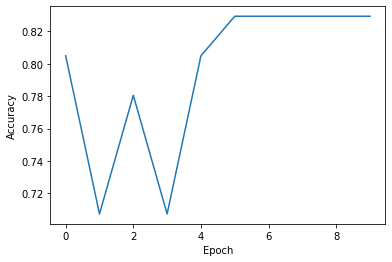

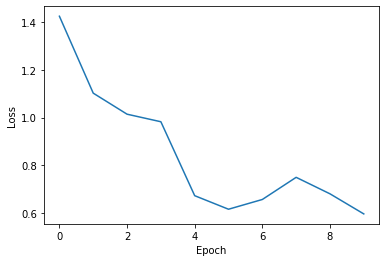

In [14]:
plt.plot(ells['accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.plot(ells['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### Training Script: `run_script.py`

In [0]:
def train(net, optimizer, criterion, epochs, batch, exp_name):
    model = net.to(device)
    total_step = len(dl)
    overall_step = 0
    losses = []
    kl_loss = []
    mseX_loss = []
    mseY_loss = []
    for epoch in range(epochs):
        model.train()
        total = 0
        running_loss = 0.0
        kl_running = 0.0
        mseX_running = 0.0
        mseY_running = 0.0

        for i, X in enumerate(dl):
            t0 = X[0].float().to(device)
            tk = X[1].float().to(device)

            xhat, yhat, z, z_mean, z_logvar = model.forward(t0,tk)
            
            loss, MSE_X, MSE_Y, KLD = criterion(xhat,t0, yhat, tk, z_mean, z_logvar)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            kl_running += KLD.item()
            mseX_running += MSE_X.item()
            mseY_running += MSE_Y.item()
            total += batch

            overall_step += 1

            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, overall_step, total_step, loss.item()))
            if i == 25:
                break

        if (epoch+1) % 10 == 0:
            for param_group in optimizer.param_groups:
                print("Current learning rate is: {}".format(param_group['lr']))
            chpt_path = base+'checkpoints/'+exp_name+'.pt'
            torch.save(model.state_dict(), chpt_path)

        losses.append(running_loss/total)     
        kl_loss.append(kl_running/total)
        mseX_loss.append(mseX_running/total)
        mseY_loss.append(mseY_running/total)  
    
    ells = {'elbo':losses,
            'kl':kl_loss,
            'mseX':mseX_loss,
            'mseY':mseY_loss}

    with open(base+'logs/'+exp_name+'_losses.pickle', 'wb') as f:
        pickle.dump(ells, f)

    left = []
    right = []
    recon_left = []
    recon_right = []
    for i, X in enumerate(dl):
        model.eval()
        t0 = X[0].float().to(device)
        tk = X[1].float().to(device)
        u = X[2].float().to(device)

        #Forward Pass
        xhat, yhat, z, z_mean, z_stdev = model.forward(t0,tk)

        left_ = t0.cpu().squeeze().numpy()
        right_ = tk.cpu().squeeze().numpy()
        xhat_ = xhat.cpu().detach().squeeze().numpy()
        yhat_ = yhat.cpu().detach().squeeze().numpy()

        left.append(left_)
        right.append(right_)
        recon_left.append(xhat_)
        recon_right.append(yhat_)
        if i == 40:
            break
    left = np.asarray(left)
    right = np.asarray(right)
    recon_left = np.asarray(recon_left)
    recon_right = np.asarray(recon_right)

    plt.plot(losses, label='ELBO')
    plt.plot(kl_loss, label='KL')
    plt.plot(mseX_loss, label='MSE')
    plt.plot(mseY_loss, label='MSE')
    plt.title('Train loss')
    plt.xlabel('epochs')
    plt.legend()

    plt.figure()
    plt.subplot(221)
    plt.imshow(left[0], cmap = 'gray')
    plt.subplot(222)
    plt.imshow(right[0], cmap = 'gray')
    plt.subplot(223)
    plt.imshow(recon_left[0], cmap = 'gray')
    plt.subplot(224)
    plt.imshow(recon_right[0], cmap = 'gray')
    plt.figure()
    plt.subplot(221)
    plt.imshow(left[30], cmap = 'gray')
    plt.subplot(222)
    plt.imshow(right[30], cmap = 'gray')
    plt.subplot(223)
    plt.imshow(recon_left[30], cmap = 'gray')
    plt.subplot(224)
    plt.imshow(recon_right[30], cmap = 'gray')


#Run from here
exp_name = 'siamese_single_test'
model = siameseCVAE(batch=batch)
# checkpoint = torch.load('/content/drive/My Drive/Colab_Notebooks/ESE546_DL_Colab/project/checkpoints/siamese_chpt.pt')
# model.load_state_dict(checkpoint) 

epochs = 1
criterion = ELBO_loss
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-3)

train(model, optimizer, criterion, epochs, batch, exp_name)

Epoch [1/10], Step [1/2398], Loss: 68553.3359


RuntimeError: ignored